# Tutorial 7e - Glass expert

This tutorial aims at demonstrating Optiland's capabilities in performing optimization on glass materials, in order to suggest a good combination to the user.

╒════╤═══════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type          │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═══════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar        │           │      inf │         inf │ Air        │       0 │        116.634  │
│  1 │ Standard      │           │     1000 │          25 │ N-BK7      │       0 │        116.634  │
│  2 │ Standard      │           │     1000 │           5 │ Air        │       0 │        111.531  │
│  3 │ Standard      │           │     1000 │          25 │ N-BK7      │       0 │        110.271  │
│  4 │ Planar        │           │      inf │          25 │ N-BK7      │       0 │        105.179  │
│  5 │ Standard      │           │     1000 │          25 │ Air        │       0 │        100.087  │
│  6 │ Stop - Planar │           │      inf │          25 │ Air        │       0 │         

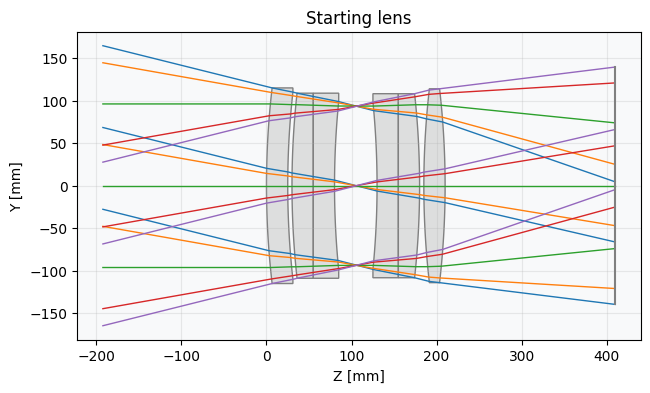

In [1]:
import optiland.backend as be
from optiland import optic, optimization
from optiland.materials import glasses_selection

target_focal_length = 100  # [mm]


class SixLensesStartPoint(optic.Optic):
    """A 6 lens design with very poor quality meant to be optimized."""

    def __init__(self):
        super().__init__()

        self.add_surface(index=0, radius=be.inf, thickness=be.inf)
        self.add_surface(index=1, radius=1000, thickness=25, material="N-BK7")
        self.add_surface(index=2, radius=1000, thickness=5.0)
        self.add_surface(index=3, radius=1000, thickness=25, material="N-BK7")
        self.add_surface(index=4, radius=be.inf, thickness=25, material="N-BK7")
        self.add_surface(index=5, radius=1000, thickness=25)
        self.add_surface(index=6, radius=be.inf, thickness=25.0, is_stop=True)
        self.add_surface(index=7, radius=-1000, thickness=25, material="N-BK7")
        self.add_surface(index=8, radius=be.inf, thickness=25, material="N-BK7")
        self.add_surface(index=9, radius=-1000, thickness=5.0)
        self.add_surface(index=10, radius=1000, thickness=25, material="N-BK7")
        self.add_surface(index=11, radius=-1000, thickness=200)
        self.add_surface(index=12)

        self.set_aperture(aperture_type="imageFNO", value=5)
        self.set_field_type(field_type="angle")

        self.add_field(y=-14)
        self.add_field(y=-10)
        self.add_field(y=0)
        self.add_field(y=10)
        self.add_field(y=14)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)


lens = SixLensesStartPoint()
lens.draw(title="Starting lens")
lens.info()

#### Operands

In [2]:
problem = optimization.OptimizationProblem()

# Real ray height to define the focal length
for k, hy in enumerate([-1, -0.714, 0, 0.714, 1]):
    input_data = {
        "optic": lens,
        "surface_number": 12,
        "Hx": 0,
        "Hy": hy,
        "Px": 0,
        "Py": 0,
        "wavelength": lens.wavelengths.primary_wavelength.value,
    }
    problem.add_operand(
        operand_type="real_y_intercept_lcs",
        target=target_focal_length * be.tan(be.deg2rad(lens.fields.y_fields[k])),
        weight=1,
        input_data=input_data,
    )

# RMS spot size - Minimize the spot size for each field at the primary wavelength.
# We choose a 'uniform' distribution, so the number of rays actually means the rays on
# one axis. Therefore we trace ≈16^2 rays here.
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "surface_number": 12,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 16,
        "wavelength": lens.wavelengths.primary_wavelength.value,
        "distribution": "uniform",
    }
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0.0,
        weight=10,
        input_data=input_data,
    )

#### Variables

In [3]:
# Radii
problem.add_variable(lens, "radius", surface_number=1, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=2, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=3, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=5, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=7, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=9, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=10, min_val=-500, max_val=500)
problem.add_variable(lens, "radius", surface_number=11, min_val=-500, max_val=500)

# Thicknesses
problem.add_variable(lens, "thickness", surface_number=1, min_val=8, max_val=20)
problem.add_variable(lens, "thickness", surface_number=2, min_val=0.4, max_val=5)
problem.add_variable(lens, "thickness", surface_number=3, min_val=8, max_val=20)
problem.add_variable(lens, "thickness", surface_number=4, min_val=3, max_val=10)
problem.add_variable(lens, "thickness", surface_number=5, min_val=10, max_val=20)
problem.add_variable(lens, "thickness", surface_number=6, min_val=10, max_val=20)
problem.add_variable(lens, "thickness", surface_number=7, min_val=3, max_val=20)
problem.add_variable(lens, "thickness", surface_number=8, min_val=8, max_val=20)
problem.add_variable(lens, "thickness", surface_number=9, min_val=0.4, max_val=5)
problem.add_variable(lens, "thickness", surface_number=10, min_val=6, max_val=20)
problem.add_variable(lens, "thickness", surface_number=11, min_val=20, max_val=45)

# First option: treat glass indexes as continuous variables
# Fast but produces fictious glasses that later need to be replaced by real glasses
# problem.add_variable(lens, "index", surface_number=1,  wavelength=0.5876, min_val=1.4, max_val=2.0)
# problem.add_variable(lens, "index", surface_number=3,  wavelength=0.5876, min_val=1.4, max_val=2.0)
# problem.add_variable(lens, "index", surface_number=4,  wavelength=0.5876, min_val=1.4, max_val=2.0)
# problem.add_variable(lens, "index", surface_number=7,  wavelength=0.5876, min_val=1.4, max_val=2.0)
# problem.add_variable(lens, "index", surface_number=8,  wavelength=0.5876, min_val=1.4, max_val=2.0)
# problem.add_variable(lens, "index", surface_number=10, wavelength=0.5876, min_val=1.4, max_val=2.0)

# Second option: use Optiland's Glass Expert to find the best combination
glasses = glasses_selection(0.4, 0.7, catalogs=["schott", "ohara"])
problem.add_variable(lens, "material", surface_number=1, glass_selection=glasses)
problem.add_variable(lens, "material", surface_number=3, glass_selection=glasses)
problem.add_variable(lens, "material", surface_number=4, glass_selection=glasses)
# problem.add_variable(lens, "material", surface_number=7,  glass_selection=glasses)
# problem.add_variable(lens, "material", surface_number=8,  glass_selection=glasses)
# problem.add_variable(lens, "material", surface_number=10, glass_selection=glasses)

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            1.30983e+06 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤══════════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type         │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪══════════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ real y intercept lcs │  -24.933 │              │              │        1 │ -66.148 │ -41.215 │           0.13 │
│  1 │ real y intercept lcs │  -17.633 │              │              │        1 │ -46.975 │ -29.342 │           0.07 │
│  2 │ real y intercept lcs │    0     │              │              │        1 │   0     │   0     │           0    │
│  3 │ real y intercept lc

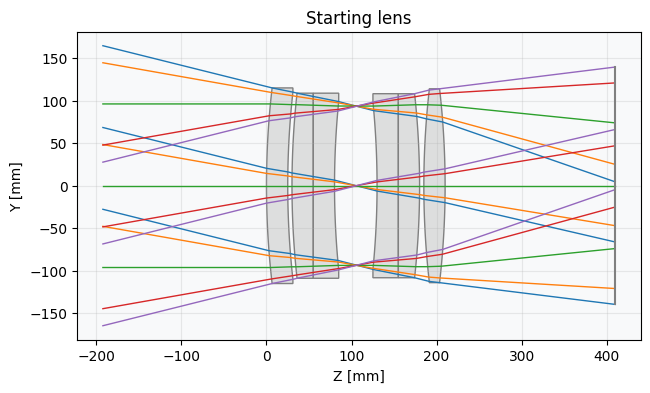

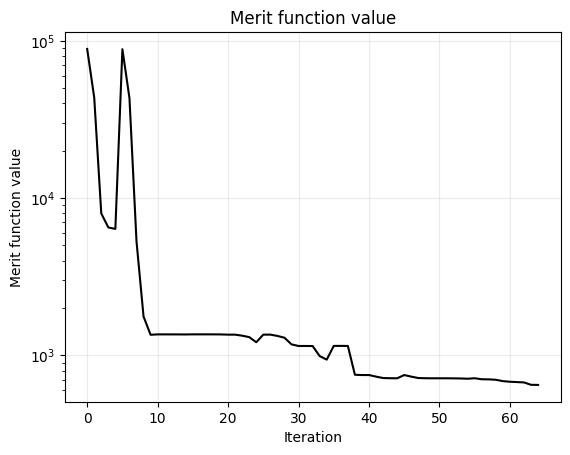

Initial error function value: 1309831.7
Initial glasses combination: ['N-BK7', 'N-BK7', 'N-BK7']

----------------------------------------------------------------------
Global exploration

Selecting Material, Surface 1:
	Trying SF2      as Material, Surface 1. Error function value: 6363.63
	Trying LAL11    as Material, Surface 1. Error function value: 1352.09
	-> Selected LAL11 as Material, Surface 1.
	New combination: ['LAL11', 'N-BK7', 'N-BK7']
	Best error function value: 1352.09 (-100%).

Selecting Material, Surface 3:
	Trying SF2      as Material, Surface 3. Error function value: 1358.31
	Trying LAL11    as Material, Surface 3. Error function value: 1359.02
	No better glass found, keeping N-BK7.
	Combination: ['LAL11', 'N-BK7', 'N-BK7']
	Best error function value: 1352.09 (0%).

Selecting Material, Surface 4:
	Trying SF2      as Material, Surface 4. Error function value: 1212.38
	Trying LAL11    as Material, Surface 4. Error function value: 1175.27
	-> Selected LAL11 as Material, S

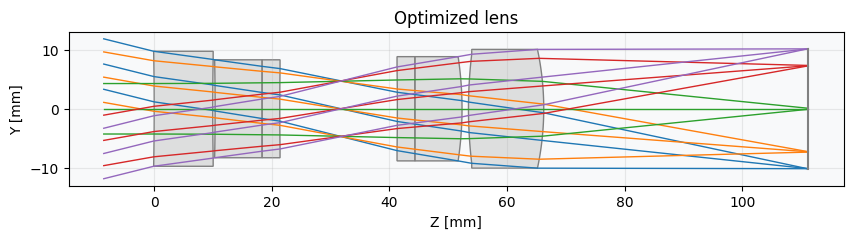

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display

import os

os.environ["OMP_NUM_THREADS"] = "12"

# As the problem has glass variables, we must use GlassExpert
optimizer = optimization.GlassExpert(problem)

# Create persistent outputs
fig_handle1 = display(display_id=True)
fig_handle2 = display(display_id=True)
fig_handle3 = display(display_id=True)

# Draw the starting lens
lens_fig = lens.draw(title="Starting lens")
fig_handle1.update(lens_fig)
plt.close(lens_fig)
del lens_fig  # Remove Python reference
import gc

gc.collect()  # Force garbage collection
print(f"Initial error function value: {problem.initial_value:.1f}")

# Define a callback that is called at each iteration of the local optimizer run.
# Used for vizualization purposes but is not recommended
# as it greatly slows down the optimization.

history = []


def callback(*args):
    # Plot the lens at each merit function call
    # lens_fig = lens.draw(title='Lens optimization')
    # fig_handle2.update(lens_fig)
    # plt.close(lens_fig)

    # Plot merit function evolution
    f_val = optimizer.problem.sum_squared()
    history.append(f_val)
    erf_fig, ax = plt.subplots()
    ax.plot(history, color="black")
    plt.yscale("log")
    ax.set_title("Merit function value")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Merit function value")
    ax.grid(alpha=0.25)
    fig_handle3.update(erf_fig)
    plt.close(erf_fig)

    # del lens_fig                 # Remove Python reference
    del erf_fig  # Remove Python reference
    import gc

    gc.collect()  # Force garbage collection


# Optimize the 6 lenses starting point
res = optimizer.run(
    num_neighbours=2,
    maxiter=5,
    tol=1e-6,
    callback=callback,
    verbose=True,
    plot_glass_map=False,
)

# Display the optimized lens
lens.draw(title="Optimized lens")
lens.info()